In [1]:
import celldancer as cd
import anndata
import numpy as np
import scipy as sp
import pandas as pd
import os

In [2]:
dataset = 'Retina'
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')
adata.obs['clusters'] = adata.obs['Annotation'].to_numpy()

In [5]:
data_path = f"{root}/data/celldancer/{dataset}"
os.makedirs(data_path, exist_ok=True)
N, G = adata.shape
#df = cd.adata_to_df_with_embed(adata,
#                               cell_type_para='clusters',
#                               embed_para='X_umap',
#                               save_path=f"{data_path}/{dataset}.csv")
df = pd.read_csv(f"{data_path}/{dataset}.csv")

In [6]:
df_loss , df = cd.velocity(df,
                           max_epoches=200,
                           permutation_ratio=0.125,
                           n_jobs=8,
                           save_path=data_path)

Using /scratch/blaauw_root/blaauw1/gyichen/data/celldancer/Retina/cellDancer_velocity_2023-04-06 10-19-11 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  250  portions.



Velocity Estimation:  88%|████████▊ | 221/250 [12:04<01:28,  3.06s/it]


Velocity Estimation: 100%|██████████| 250/250 [13:32<00:00,  3.11s/it]
                                                                      

In [7]:
n_neigh = adata.uns['neighbors']['indices'].shape[1]
df = cd.compute_cell_velocity(cellDancer_df=df,
                              projection_neighbor_choice="gene",
                              expression_scale='power10',
                              projection_neighbor_size=n_neigh,
                              speed_up=(100, 100))

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████| 9680/9680 [00:01<00:00, 6400.85it/s]


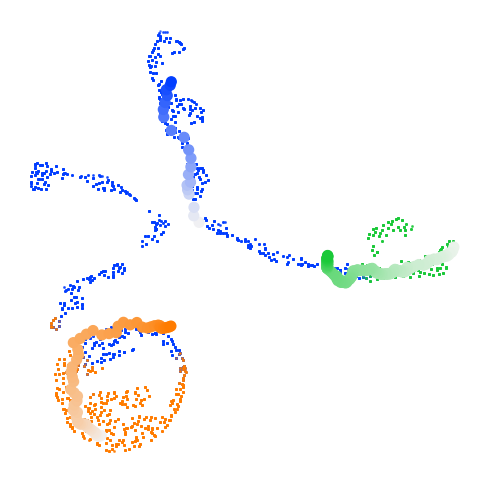

There are 3 clusters.
[0 1 2]
--- 198.06984090805054 seconds ---


In [8]:
# estimate pseudotime
dt = 0.05
n_repeats = 10
t_total = {dt: int(10/dt)}
df = cd.pseudo_time(cellDancer_df=df,
                    grid=(30, 30),
                    dt=dt,
                    t_total=t_total[dt],
                    n_repeats=n_repeats,
                    speed_up=(100, 100),
                    n_paths=3,
                    plot_long_trajs=True,
                    psrng_seeds_diffusion=[i for i in range(n_repeats)],
                    n_jobs=8)

In [10]:
df.to_csv(f"{data_path}/{dataset}_out.csv")

In [11]:
df.head()

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2,pseudotime
0,0,Mon2,0.083990,0.033757,0.087467,0.034707,0.140791,0.247420,0.282257,0.030053,r8AAACCTGAGTGGACGT,RGC,10.859646,0.206025,0,0.016433,-0.002430,0.449870
1,1,Mon2,0.084583,0.000000,0.092327,0.017494,0.160488,0.243444,0.277537,0.030053,r8AAACCTGGTCGAATCT,AC/HC,-0.021897,8.195225,1,-0.333249,0.483850,0.579740
2,2,Mon2,0.167898,0.159704,0.142394,0.114324,0.134384,0.258796,0.293907,0.030053,r8AAACCTGTCAGTCCCT,PR,-5.928886,5.706328,2,0.005801,-0.026048,0.574675
3,3,Mon2,0.108383,0.040634,0.107379,0.043323,0.154735,0.247205,0.281769,0.030053,r8AAACCTGTCCAAACAC,RGC,10.414387,0.475553,3,NaN,NaN,0.486753
4,4,Mon2,0.199806,0.077438,0.176505,0.081133,0.181925,0.248370,0.283317,0.030053,r8AAACGGGCACTGAAGG,RGC,3.984768,1.298921,4,NaN,NaN,0.479740


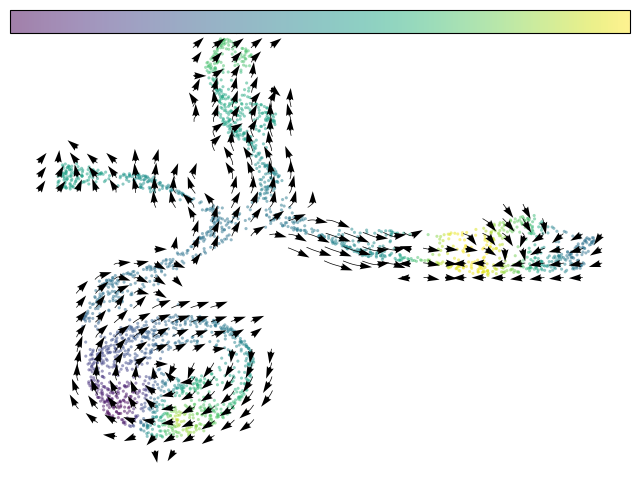

In [12]:
import matplotlib.pyplot as plt
import celldancer.cdplt as cdplt
fig, ax = plt.subplots(figsize=(8,6))
im=cdplt.scatter_cell(ax,
                      df,
                      colors='pseudotime',
                      alpha=0.5,
                      velocity=True)
ax.axis('off')
fig.savefig(f"{data_path}/cd_time_{dataset}.png")

# Save results to .h5ad file

In [2]:
dataset = "Retina"
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f"{root}/data/{dataset}_pp.h5ad")
df = pd.read_csv(f"{root}/data/celldancer/{dataset}/{dataset}_out.csv")

In [3]:
N, G = adata.shape

time = df["pseudotime"].to_numpy().reshape(G, N).T

adata.layers["cd_alpha"] = df["alpha"].to_numpy().reshape(G, N).T
adata.layers["cd_beta"] = df["beta"].to_numpy().reshape(G, N).T
adata.layers["cd_gamma"] = df["gamma"].to_numpy().reshape(G, N).T
adata.layers["cd_velocity_u"] = (df["unsplice_predict"].to_numpy().reshape(G, N)
                                 - df["unsplice"].to_numpy().reshape(G, N)).T
adata.layers["cd_velocity"] = (df["splice_predict"].to_numpy().reshape(G, N)
                               - df["splice"].to_numpy().reshape(G, N)).T
adata.obs["cd_time"] = time[:, 0]

data_path = f"{root}/data/celldancer/{dataset}"
adata.write_h5ad(f"{data_path}/{dataset}.h5ad")